# 4. Cartesian perodic under-sampling along parallel lines

Here the goal is to illustrate the typical artifacts of standard
**deterministic** **regular** (or **periodic**) undersampling along the phase
encoding direction (here $k_y$) used in parallel imaging. Below we illustrate
the following cases:
1. full Cartesian sampling $R= n/m = 1$ where $n=N^2$ is the image size, $N$ the image dimension and $m$ the number of measurements in k-space:
2. undersampling with a factor $R=2$
3. undersampling with a factor $R=4$
4. undersampling with a factor $R=8$


- Author: Philippe Ciuciu (philippe.ciuciu@cea.fr)
- Date: 06/24/2022
- Date: 04/02/2025 (brainweb compatibility)
- Target: [IEEE EMBS-SPS Summer School](http://conferences.imt-atlantique.fr/ieeess/index.php?pid=1) on **Novel acquisition and image reconstruction strategies in accelerated Magnetic Resonance Imaging**

(256, 256)


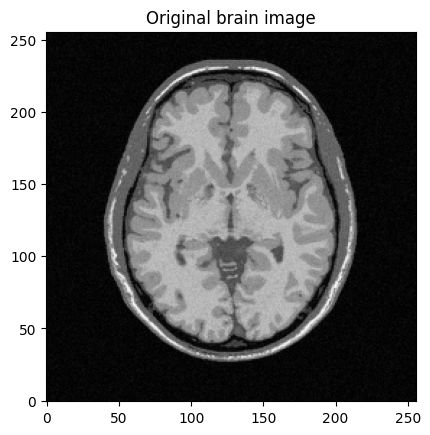

In [5]:
#DISPLAY BRAIN PHANTOM
%matplotlib inline

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib.pyplot as plt
import sys

from skimage import data, io, filters

import pywt as pw
import matplotlib.pyplot as plt

import brainweb_dl as bwdl

#Previousmly we used numerical phantoms
if 0:
    cwd = os.getcwd()
    dirimg_2d = op.join(cwd,"..", "data")
    img_size = 512   #256
    FOV = 0.2 #field of view in meters
    pixelSize = FOV/img_size
    #load data file corresponding to the target resolution
    filename = "BrainPhantom" + str(img_size) + ".png"
    mri_filename = op.join(dirimg_2d, filename)
    mri_img = io.imread(mri_filename, as_gray=True)
    plt.figure()
    plt.title("Brain Phantom, size = "+ str(img_size))
    if mri_img.ndim == 2:
        plt.imshow(mri_img, cmap=plt.cm.gray)
    else:
        plt.imshow(mri_img)
    plt.show()

plt.rcParams["image.origin"]="lower"
plt.rcParams["image.cmap"]='Greys_r'

mri_img = bwdl.get_mri(4, "T1")[70, ...].astype(np.float32)
#mri_img = bwdl.get_mri(5, "T2")[150, ...].astype(np.float32)
print(mri_img.shape)
img_size = mri_img.shape[0]
plt.figure()
plt.imshow(abs(mri_img))
plt.title("Original brain image")
plt.show()


Text(0.5, 1.0, 'Cartesian recon')

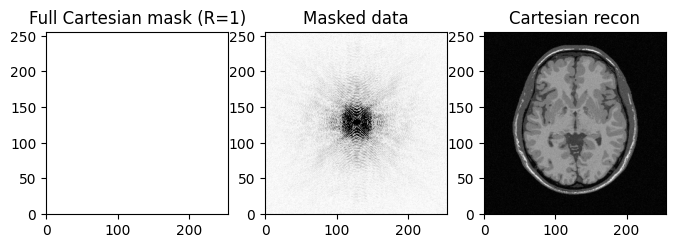

In [6]:
kspace_mask_full = np.ones((img_size, img_size), dtype="float64")

#import numpy.fft as fft
norm = "ortho"
def fft(x):
    return np.fft.fft2(x, norm=norm)

def ifft(x):
    return np.fft.ifft2(x, norm=norm)

# Generate the subsampled kspace with R=2
kspace_data = np.fft.fftshift(fft(mri_img))   # put the 0-freq in the middle of axes as

# Generate the kspace data: first Fourier transform the image
kspace_data = np.fft.fftshift(fft(mri_img))
#add Gaussian complex-valued random noise
signoise = 10
#kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Simulate independent noise realization on the real & imag parts
kspace_data += (np.random.randn(*mri_img.shape) + 1j * np.random.randn(*mri_img.shape)) * signoise
# Mask data to perform subsampling
kspace_data *= kspace_mask_full

# Zero order solution
image_rec0 = ifft(np.fft.ifftshift(kspace_data))

fig, axs = plt.subplots(1, 3, figsize=(8, 8) )
axs[0].imshow(kspace_mask_full, cmap='gray_r')
axs[0].set_title("Full Cartesian mask (R=1)")
axs[1].imshow(np.abs(kspace_data),  cmap='gray_r', vmax=.01*np.abs(kspace_data).max())
axs[1].set_title("Masked data")
axs[2].imshow(np.abs(image_rec0), cmap='gray')
axs[2].set_title("Cartesian recon")

2-fold undersampling, m=  128
4-fold undersampling, m=  64
8-fold undersampling, m=  32


Text(0.5, 1.0, 'Cartesian regular under-sampling mask (R=8)')

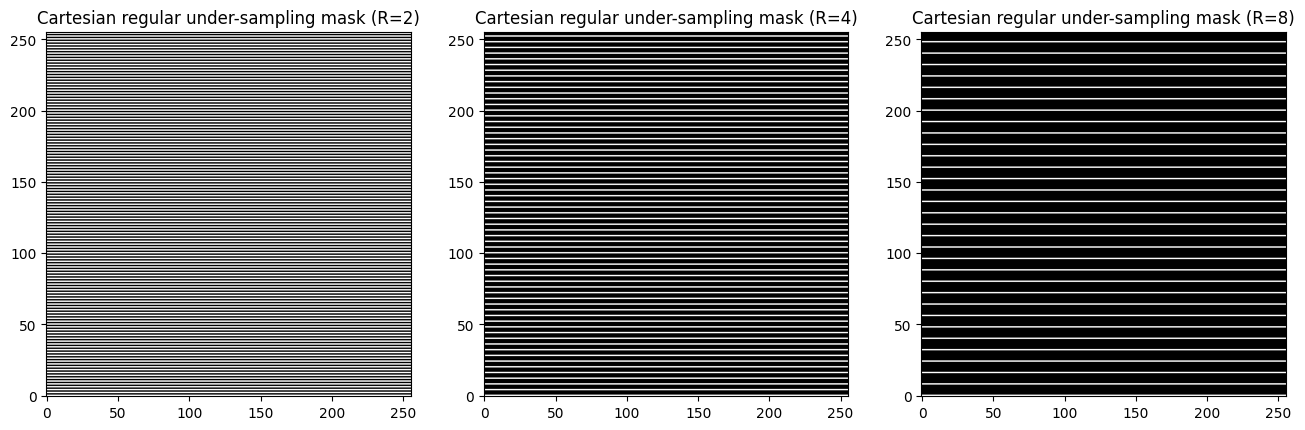

In [7]:
import numpy.matlib as mlib

# generate Cartesian lines in a straightforward manner
#a = (np.linspace(0,img_size,img_size+1))/img_size -0.5    # work in normalized frequency
r2 = (int)(img_size/2)
r4 = (int)(img_size/4)
r8 = (int)(img_size/8)
print("2-fold undersampling, m= ", r2)
print("4-fold undersampling, m= ", r4)
print("8-fold undersampling, m= ", r8)

selected_ksp_line = np.ones((1, img_size), dtype="float64")
skipped_ksp_line = np.zeros((1, img_size), dtype="float64")
k_space_pattern_r2 = np.concatenate((selected_ksp_line, skipped_ksp_line), axis=0)
kspace_mask_r2 = np.tile(k_space_pattern_r2, (r2, 1))

#k_space_pattern_r4 = np.concatenate((selected_ksp_line, skipped_ksp_line, skipped_ksp_line,skipped_ksp_line), axis=0)
k_space_pattern_r4 = np.concatenate((selected_ksp_line, np.tile(skipped_ksp_line, (3,1))), axis=0)
kspace_mask_r4 = np.tile(k_space_pattern_r4, (r4, 1))

k_space_pattern_r8 = np.concatenate((selected_ksp_line, np.tile(skipped_ksp_line, (7,1))), axis=0)
kspace_mask_r8 = np.tile(k_space_pattern_r8, (r8, 1))


fig, axs = plt.subplots(1, 3, figsize=(16, 16) )
axs[0].imshow(kspace_mask_r2) #, cmap='Greys_r'
axs[0].set_title("Cartesian regular under-sampling mask (R=2)")
axs[1].imshow(kspace_mask_r4, cmap='Greys_r')
axs[1].set_title("Cartesian regular under-sampling mask (R=4)")
axs[2].imshow(kspace_mask_r8, cmap='Greys_r')
axs[2].set_title("Cartesian regular under-sampling mask (R=8)")

* Generate undersampled data for $R=2$ and perform image reconstruction
* What do you observe?

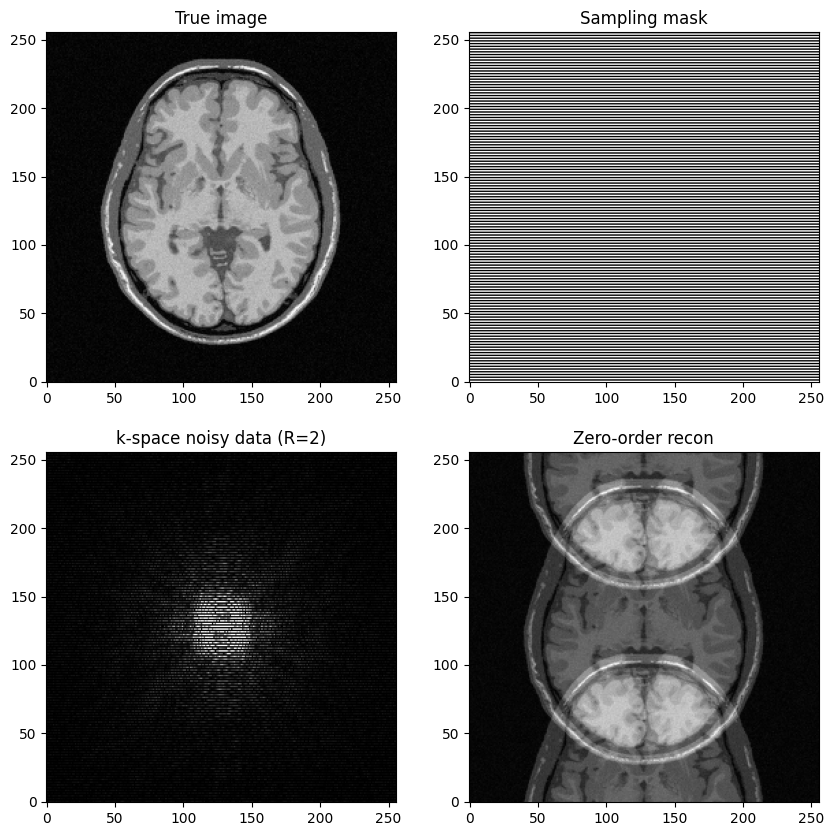

In [8]:
# Generate the kspace data: first Fourier transform the image
kspace_data_r2 = np.fft.fftshift(fft(mri_img))
#add Gaussian complex-valued random noise
signoise = 10
# Simulate independent noise realization on the real & imag parts
kspace_data_r2 += (np.random.randn(*mri_img.shape) + 1j * np.random.randn(*mri_img.shape)) * signoise

# Mask data to perform subsampling
kspace_data_r2 *= kspace_mask_r2

# Zero order image reconstruction
image_rec0_r2 = ifft(np.fft.ifftshift(kspace_data_r2))

fig, axs = plt.subplots(2, 2, figsize=(10, 10) )
axs[0,0].imshow(mri_img, cmap='Greys_r')
axs[0,0].set_title("True image")
axs[0,1].imshow(kspace_mask_r2, cmap='Greys_r')
axs[0,1].set_title("Sampling mask")
axs[1,0].imshow(np.abs(kspace_data_r2),  cmap='gray', vmax=0.01*np.abs(kspace_data_r2).max())
#axs[1].imshow(np.abs(np.fft.ifftshift(kspace_data)), cmap='Greys_r')
axs[1,0].set_title("k-space noisy data (R=2)")
axs[1,1].imshow(np.abs(image_rec0_r2), cmap='gray')
axs[1,1].set_title("Zero-order recon")
plt.show()

* Generate undersampled data for $R=4$ and perform image reconstruction
* What do you observe?

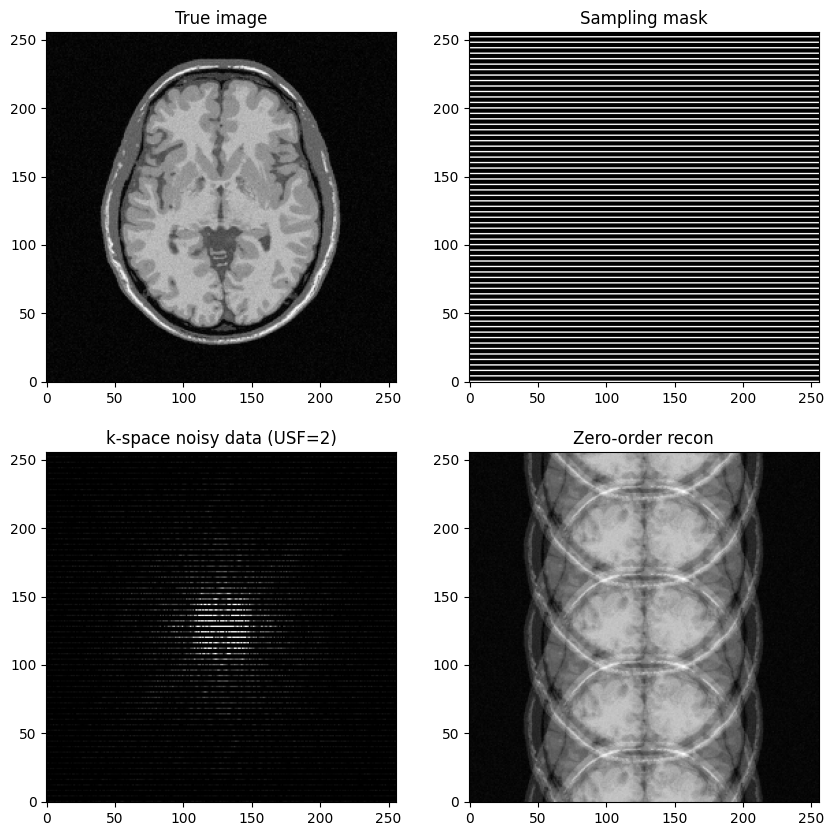

In [9]:
# Generate the kspace data: first Fourier transform the image
kspace_data_r4 = np.fft.fftshift(fft(mri_img))
#add Gaussian complex-valued random noise
signoise = 10
# Simulate independent noise realization on the real & imag parts
kspace_data_r4 += (np.random.randn(*mri_img.shape) + 1j * np.random.randn(*mri_img.shape)) * signoise
# Mask data to perform subsampling
kspace_data_r4 *= kspace_mask_r4

# Zero order image reconstruction
image_rec0_r4 = ifft(np.fft.ifftshift(kspace_data_r4))

fig, axs = plt.subplots(2, 2, figsize=(10, 10) )
axs[0,0].imshow(mri_img, cmap='Greys_r')
axs[0,0].set_title("True image")
axs[0,1].imshow(kspace_mask_r4, cmap='Greys_r')
axs[0,1].set_title("Sampling mask")
axs[1,0].imshow(np.abs(kspace_data_r4),  cmap='gray', vmax=0.01*np.abs(kspace_data_r4).max())
axs[1,0].set_title("k-space noisy data (USF=2)")
axs[1,1].imshow(np.abs(image_rec0_r4), cmap='Greys_r')
axs[1,1].set_title("Zero-order recon")
plt.show()

* Generate undersampled data for $R=8$ and perform image reconstruction
* What do you observe?

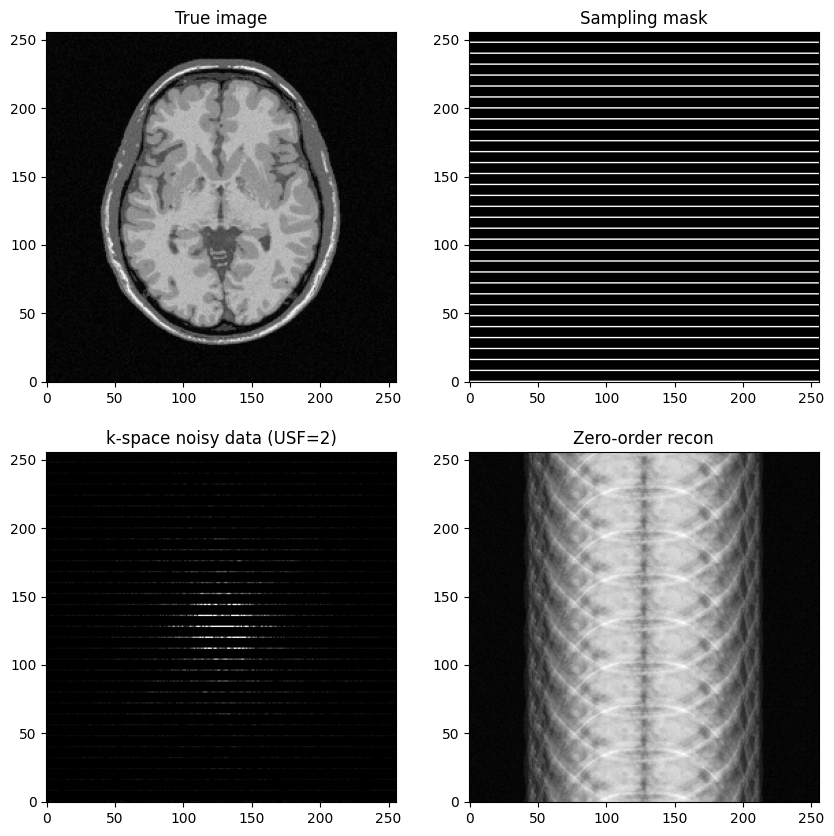

In [10]:
# Generate the kspace data: first Fourier transform the image
kspace_data_r8 = np.fft.fftshift(fft(mri_img))
#add Gaussian complex-valued random noise
signoise = 10
# Simulate independent noise realization on the real & imag parts
kspace_data_r8 += (np.random.randn(*mri_img.shape) + 1j * np.random.randn(*mri_img.shape)) * signoise
# Mask data to perform subsampling
kspace_data_r8 *= kspace_mask_r8

# Zero order image reconstruction
image_rec0_r8 = ifft(np.fft.ifftshift(kspace_data_r8))

fig, axs = plt.subplots(2, 2, figsize=(10, 10) )
axs[0,0].imshow(mri_img, cmap='Greys_r')
axs[0,0].set_title("True image")
axs[0,1].imshow(kspace_mask_r8, cmap='Greys_r')
axs[0,1].set_title("Sampling mask")
axs[1,0].imshow(np.abs(kspace_data_r8),  cmap='gray', vmax=0.01*np.abs(kspace_data_r4).max())
axs[1,0].set_title("k-space noisy data (USF=2)")
axs[1,1].imshow(np.abs(image_rec0_r8), cmap='Greys_r')
axs[1,1].set_title("Zero-order recon")
plt.show()

<div class="alert alert-success">
    <b>QUESTION</b>:
     <ul>
      <li>Do you know what key ingredient may help to recover the reference image pretty well while still using these regular under-sampling patterns? </li>
    </ul>
</div>
